[*********************100%***********************]  1 of 1 completed

SN: Downloading stock data...
SN: Data saved to data/AAPL_stock_data.csv
SN: DataFrame preview before writing to SQLite:
        Date       Close  MA_20  Daily Return
0 2023-01-03  123.632530    NaN           NaN
1 2023-01-04  124.907707    NaN      0.010314
2 2023-01-05  123.583099    NaN     -0.010605
3 2023-01-06  128.130234    NaN      0.036794
4 2023-01-09  128.654144    NaN      0.004089
SN: Loaded data into stock_data.db
SN: Generating visualizations...


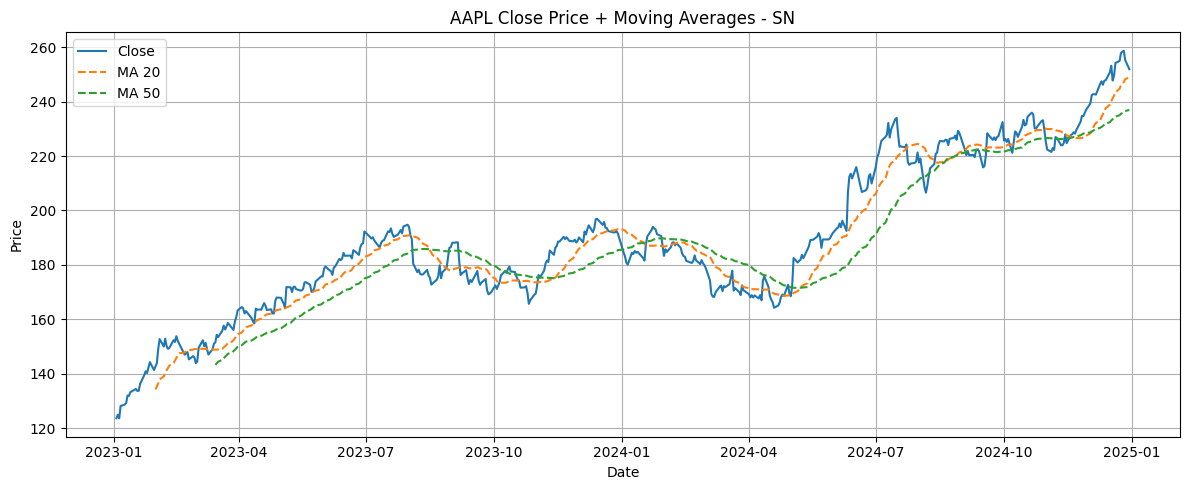

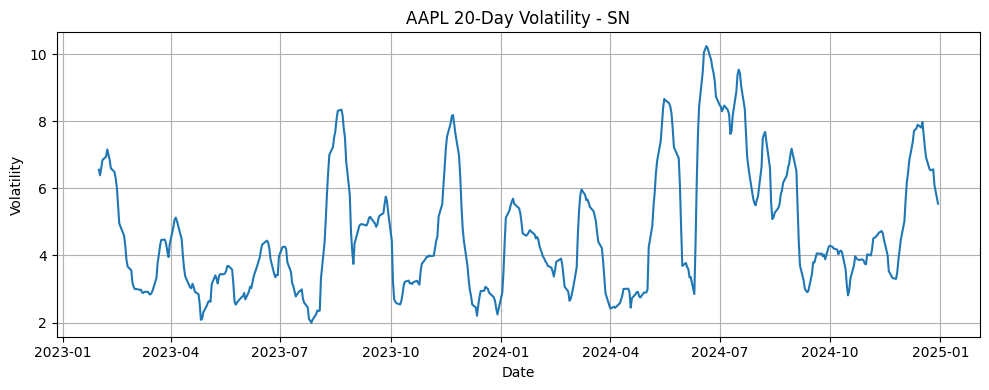

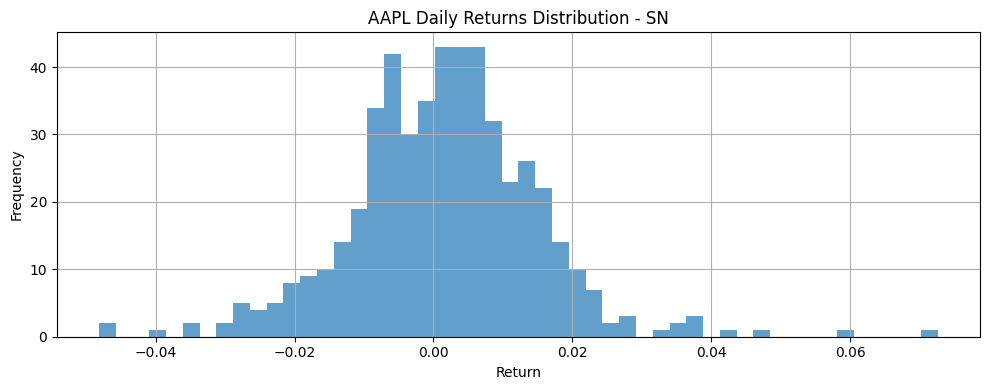

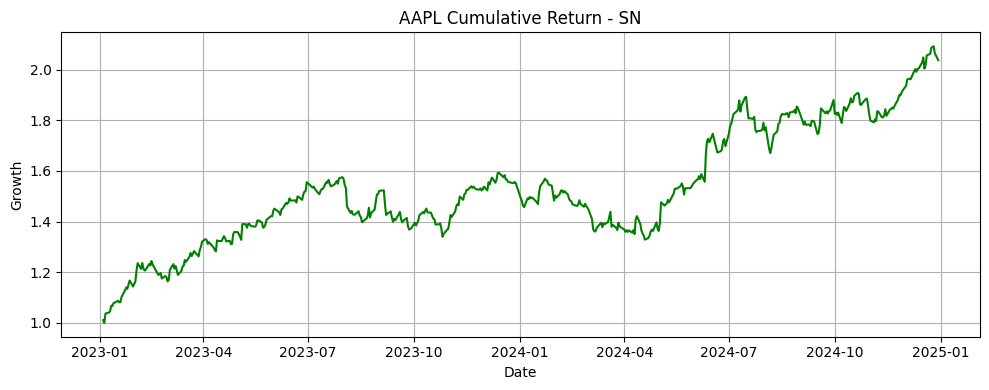

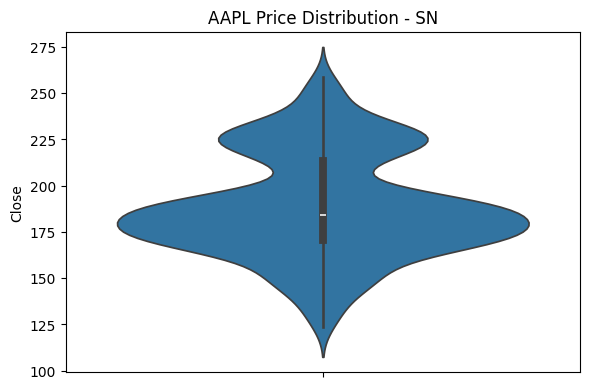

SN: Sample from database:
                  Date       Close       MA_20  Daily Return
0  2024-12-30 00:00:00  251.923019  248.994234     -0.013263
1  2024-12-27 00:00:00  255.309296  248.251551     -0.013242
2  2024-12-26 00:00:00  258.735504  247.219685      0.003176
3  2024-12-24 00:00:00  257.916443  246.023002      0.011478
4  2024-12-23 00:00:00  254.989655  244.757892      0.003065


In [7]:
# Stock Market Data Pipeline with Stats and Visuals - SN

import yfinance as yf
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setup
os.makedirs("data", exist_ok=True)
ticker = "AAPL"
start_date = "2023-01-01"
end_date = "2024-12-31"
csv_path = f"data/{ticker}_stock_data.csv"
db_path = "stock_data.db"

# Step 1: Download stock data
print("SN: Downloading stock data...")
df = yf.download(ticker, start=start_date, end=end_date)

# 🔥 FIX: Flatten multi-level columns (if any)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

if df.empty:
    raise ValueError("SN: No data downloaded. Check ticker symbol or date range.")

df.reset_index(inplace=True)  # Make 'Date' a column
df.to_csv(csv_path, index=False)
print("SN: Data saved to", csv_path)

# Step 2: Feature engineering
df["MA_20"] = df["Close"].rolling(window=20).mean()
df["MA_50"] = df["Close"].rolling(window=50).mean()
df["Volatility_20"] = df["Close"].rolling(window=20).std()
df["Daily Return"] = df["Close"].pct_change()
df["Cumulative Return"] = (1 + df["Daily Return"]).cumprod()

# Confirm before saving to DB
print("SN: DataFrame preview before writing to SQLite:")
print(df[["Date", "Close", "MA_20", "Daily Return"]].head())

# Step 3: Load into SQLite
conn = sqlite3.connect(db_path)
df.to_sql(f"{ticker}_stocks", conn, if_exists="replace", index=False)
conn.commit()
print("SN: Loaded data into", db_path)

# Step 4: Visualizations
print("SN: Generating visualizations...")

# Price + MAs
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"], label="Close")
plt.plot(df["Date"], df["MA_20"], label="MA 20", linestyle="--")
plt.plot(df["Date"], df["MA_50"], label="MA 50", linestyle="--")
plt.title(f"{ticker} Close Price + Moving Averages - SN")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Volatility
plt.figure(figsize=(10, 4))
plt.plot(df["Date"], df["Volatility_20"], label="20-Day Std Dev")
plt.title(f"{ticker} 20-Day Volatility - SN")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()

# Daily Returns Histogram
plt.figure(figsize=(10, 4))
df["Daily Return"].plot.hist(bins=50, alpha=0.7)
plt.title(f"{ticker} Daily Returns Distribution - SN")
plt.xlabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# Cumulative Return
plt.figure(figsize=(10, 4))
plt.plot(df["Date"], df["Cumulative Return"], color="green")
plt.title(f"{ticker} Cumulative Return - SN")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.grid(True)
plt.tight_layout()
plt.show()

# Price Distribution Violin
if df["Close"].dropna().shape[0] > 0:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=df, y="Close", inner="box")
    plt.title(f"{ticker} Price Distribution - SN")
    plt.tight_layout()
    plt.show()
else:
    print("SN: Skipping violin plot — 'Close' column is empty or invalid.")

# Step 5: SQL Preview
query = f"""
SELECT "Date", "Close", "MA_20", "Daily Return"
FROM {ticker}_stocks
ORDER BY "Date" DESC
LIMIT 5
"""
try:
    preview = pd.read_sql(query, conn)
    print("SN: Sample from database:")
    print(preview)
except Exception as e:
    print("SN: SQL query failed:", e)
